In [1]:
! pip install orion-ml
#! pip install 'urllib3!=1.25.0,!=1.25.1,<1.26,>=1.21.1'

! git clone https://github.com/signals-dev/Orion.git
! mv Orion/tutorials/tulog/* .

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 106 kB 14.3 MB/s 
     |████████████████████████████████| 180 kB 48.4 MB/s 
     |████████████████████████████████| 2.5 MB 61.7 MB/s 
     |████████████████████████████████| 149 kB 65.1 MB/s 
     |████████████████████████████████| 17.3 MB 62.9 MB/s 
     |████████████████████████████████| 5.4 MB 61.3 MB/s 
     |████████████████████████████████| 10.1 MB 24.7 MB/s 
     |████████████████████████████████| 377 kB 65.0 MB/s 
     |████████████████████████████████| 2.9 MB 67.5 MB/s 
     |████████████████████████████████| 85 kB 3.8 MB/s 
     |████████████████████████████████| 50 kB 6.7 MB/s 
     |████████████████████████████████| 110.5 MB 1.3 kB/s 
     |████████████████████████████████| 240 kB 64.4 MB/s 
     |████████████████████████████████| 25.4 MB 1.2 MB/s 
     |████████████████████████████████| 1.5 MB 58.5 MB/s 
     |██████████████████████████

Cloning into 'Orion'...
remote: Enumerating objects: 7680, done.
remote: Counting objects: 100% (935/935), done.
remote: Compressing objects: 100% (274/274), done.
remote: Total 7680 (delta 820), reused 693 (delta 661), pack-reused 6745
Receiving objects: 100% (7680/7680), 27.98 MiB | 21.13 MiB/s, done.
Resolving deltas: 100% (5911/5911), done.


In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import os
import zipfile
import warnings
from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns
import time
from scipy import stats
from typing import Tuple
import logging
from scipy.optimize import fmin

# need module making TadGAN
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_absolute_error

from tensorflow.python import keras
from keras import backend as K # Theano(th)와 Tensorflow(tf) 모두와 호환이 되는 Keras모듈을 작성하고자 한다면 Keras 백엔드 API를 사용
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.losses import MeanSquaredLogarithmicError

warnings.filterwarnings('ignore')
drive.mount('/content/drive')
pd.options.display.max_columns = 999

Using TensorFlow backend.


Mounted at /content/drive


In [12]:
# reading .zip file

dataset_dir = '/content/drive/MyDrive/dataset.zip'
my_zip = zipfile.ZipFile(dataset_dir).extractall('/content/drive/MyDrive')

my_zip_list = []
def file_list(dir):
  files = os.listdir(dir)
  for file in files:
    if os.path.isdir(dir + '/' +file) == True:
      file_list(dir + '/'+file)
    else:
      file_dir = dir + '/' + file
      my_zip_list.append(file_dir)
      print(dir + '/' +file)
if __name__ == '__main__':
  dir = r'/content/drive/MyDrive/dataset'
  file_list(dir)

for ls in tqdm(my_zip_list):
  if '.csv' in ls:
    ls_sp = ls.split('/')[-1]
    globals()['{}'.format(ls_sp[:-4])] = pd.read_csv(ls)
    print(ls_sp)

/content/drive/MyDrive/dataset/[네트워크 지능화를 위한 인공지능 해커톤] 데이터 이용관련 동의서_paul77ms.pdf
/content/drive/MyDrive/dataset/data/IP/DHCP.csv
/content/drive/MyDrive/dataset/data/Media/Media_INFO.csv
/content/drive/MyDrive/dataset/data/Media/Media_STREAM.csv
/content/drive/MyDrive/dataset/data/Media/Media_MENU.csv
/content/drive/MyDrive/dataset/data/Media/Media_LOGIN.csv
/content/drive/MyDrive/dataset/Media.py
/content/drive/MyDrive/dataset/IP.py


  0%|          | 0/8 [00:00<?, ?it/s]

DHCP.csv


 38%|███▊      | 3/8 [00:00<00:00, 13.22it/s]

Media_INFO.csv
Media_STREAM.csv


 62%|██████▎   | 5/8 [00:00<00:00,  5.61it/s]

Media_MENU.csv


100%|██████████| 8/8 [00:01<00:00,  6.65it/s]

Media_LOGIN.csv


Timestamp: [YYYYMMDD_HHmm(a)-HHmm(b)] 형식을 가지며,

수집 범위는 YYYY년 MM월 DD일 HH시 mm분(a)부터 HH시 mm분(b)

Svr_detect: 수집 시점에 클라이언트 단말이 DHCP 서버에게 연결을 요청하는 단계를 진행 중인 수

Svr_connect: 수집 시점에 클라이언트 단말과 DHCP 서버 간의 연결 확립 단계를 진행 중인 수

Ss_request: 수집 시점에 DHCP 서버와 연결된 클라이언트 단말이 IP 할당을 요청하는 단계를 진행 중인

Ss_established: 수집 시점에 DHCP 서버가 클라이언트 단말에게 할당 완료한 IP 수

In [13]:
DHCP.head()

Timestamp  Svr_detect  Svr_connect  Ss_request  Ss_Established
0  20210101_0000-0010         0.0          0.0         5.0             8.0
1  20210101_0010-0020         0.0          0.0         4.0            14.0
2  20210101_0020-0030         0.0          0.0         1.0            10.0
3  20210101_0030-0040         0.0          0.0         1.0            14.0
4  20210101_0040-0050         0.0          0.0         2.0             9.0

In [14]:
DHCP.shape

(52560, 5)

In [15]:
# 월 별 데이터 저장 (ex : df_1, df_2, df_3 ... df_12)
for tm in range(1,13):
  if len(str(tm)) > 1:
    globals()['df_{}'.format(tm)] = DHCP[DHCP.Timestamp.str[4:6] == str(tm)]
  else:
    globals()['df_{}'.format(tm)] = DHCP[DHCP.Timestamp.str[4:6] == '0'+str(tm)]

# df_1.shape, df_2.shape, df_3.shape, df_4.shape, df_5.shape, df_6.shape, df_7.shape, df_8.shape, df_9.shape, df_10.shape, df_11.shape, df_12.shape

Svr_detect/Svr_connect/Ss_request 합계의 이상 추이는 서버부 이상을, Ss_established의 이상 추이는 단말부 이상을 의미함. 
* **서버부와 단말부 둘 중 하나라도 이상이라면 최종 이상이라 간주.**

In [16]:
Server_anomaly = ['Svr_detect','Svr_connect','Ss_request']
DHCP['Server_anomaly'] = DHCP[Server_anomaly[0]] + DHCP[Server_anomaly[1]] + DHCP[Server_anomaly[2]]
DHCP.rename(index = {'Ss_established':'Terminal_anomaly'}, inplace = True)

In [17]:
"""def rolling_window(df, col, window):
  df[col+'_'+str(window)] = df[col].rolling(window = window).mean()
  return df

rolling_window(DHCP, 'Ss_Established', 100)
rolling_window(DHCP, 'Server_anomaly', 100)"""

"def rolling_window(df, col, window):\n  df[col+'_'+str(window)] = df[col].rolling(window = window).mean()\n  return df\n\nrolling_window(DHCP, 'Ss_Established', 100)\nrolling_window(DHCP, 'Server_anomaly', 100)"

In [18]:
"""# Svr_detect - Svr_connect
# Ss_request - Ss_Established

def request_success(df):
  df.copy()
  Svr_cols = df.columns[df.columns.str.contains('Svr') == True]
  Ss_cols = df.columns[df.columns.str.contains('Ss') == True]
  df['{}_{}'.format(Svr_cols[0], Svr_cols[1])] = df[Svr_cols[0]] - df[Svr_cols[1]]
  df['{}_{}'.format(Ss_cols[0], Ss_cols[1])] = df[Ss_cols[0]] - df[Ss_cols[1]]
  return df

DHCP = request_success(DHCP)"""

"# Svr_detect - Svr_connect\n# Ss_request - Ss_Established\n\ndef request_success(df):\n  df.copy()\n  Svr_cols = df.columns[df.columns.str.contains('Svr') == True]\n  Ss_cols = df.columns[df.columns.str.contains('Ss') == True]\n  df['{}_{}'.format(Svr_cols[0], Svr_cols[1])] = df[Svr_cols[0]] - df[Svr_cols[1]]\n  df['{}_{}'.format(Ss_cols[0], Ss_cols[1])] = df[Ss_cols[0]] - df[Ss_cols[1]]\n  return df\n\nDHCP = request_success(DHCP)"

In [19]:
def graph(col):
  plt.suptitle(col)
  shapes = [0, df_1.shape[0], df_2.shape[0], df_3.shape[0], df_4.shape[0], df_5.shape[0], df_6.shape[0], df_7.shape[0], df_8.shape[0], df_9.shape[0], df_10.shape[0], df_11.shape[0], df_12.shape[0]]
  fig, (ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12) = plt.subplots(nrows=12)
  axes = [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]
  fig.set_size_inches(60,30)
  fig.tight_layout()
  total = 0
  total_a = 0
  for i,s in enumerate(shapes):
    if i==12:
      break
    total += shapes[i]
    total_a += shapes[i+1]

    axes[i].plot(DHCP.Timestamp[total:total_a].str[-8:], DHCP[col][total:total_a],'.-')
    axes[i].set_title('{}Month_{}'.format(i+1, col))

def plot_ts(X, labels=None):
    fig = plt.figure(figsize=(30, 6))
    ax = fig.add_subplot(111)
    
    if not isinstance(X, list):
        X = [X]
  
    for x in X:
        t = range(len(x))
        plt.plot(t, x)
    
    #plt.title('', size=34)
    plt.xlabel('Timestamp', size=30)
    plt.ylabel('values', size=30)
    plt.xticks(size=26)
    plt.yticks(size=26)
    plt.xlim([t[0], t[-1]])
    
    if labels:
        plt.legend(labels=labels, loc=1, prop={'size': 26})
    
    plt.show()

<Figure size 432x288 with 0 Axes>

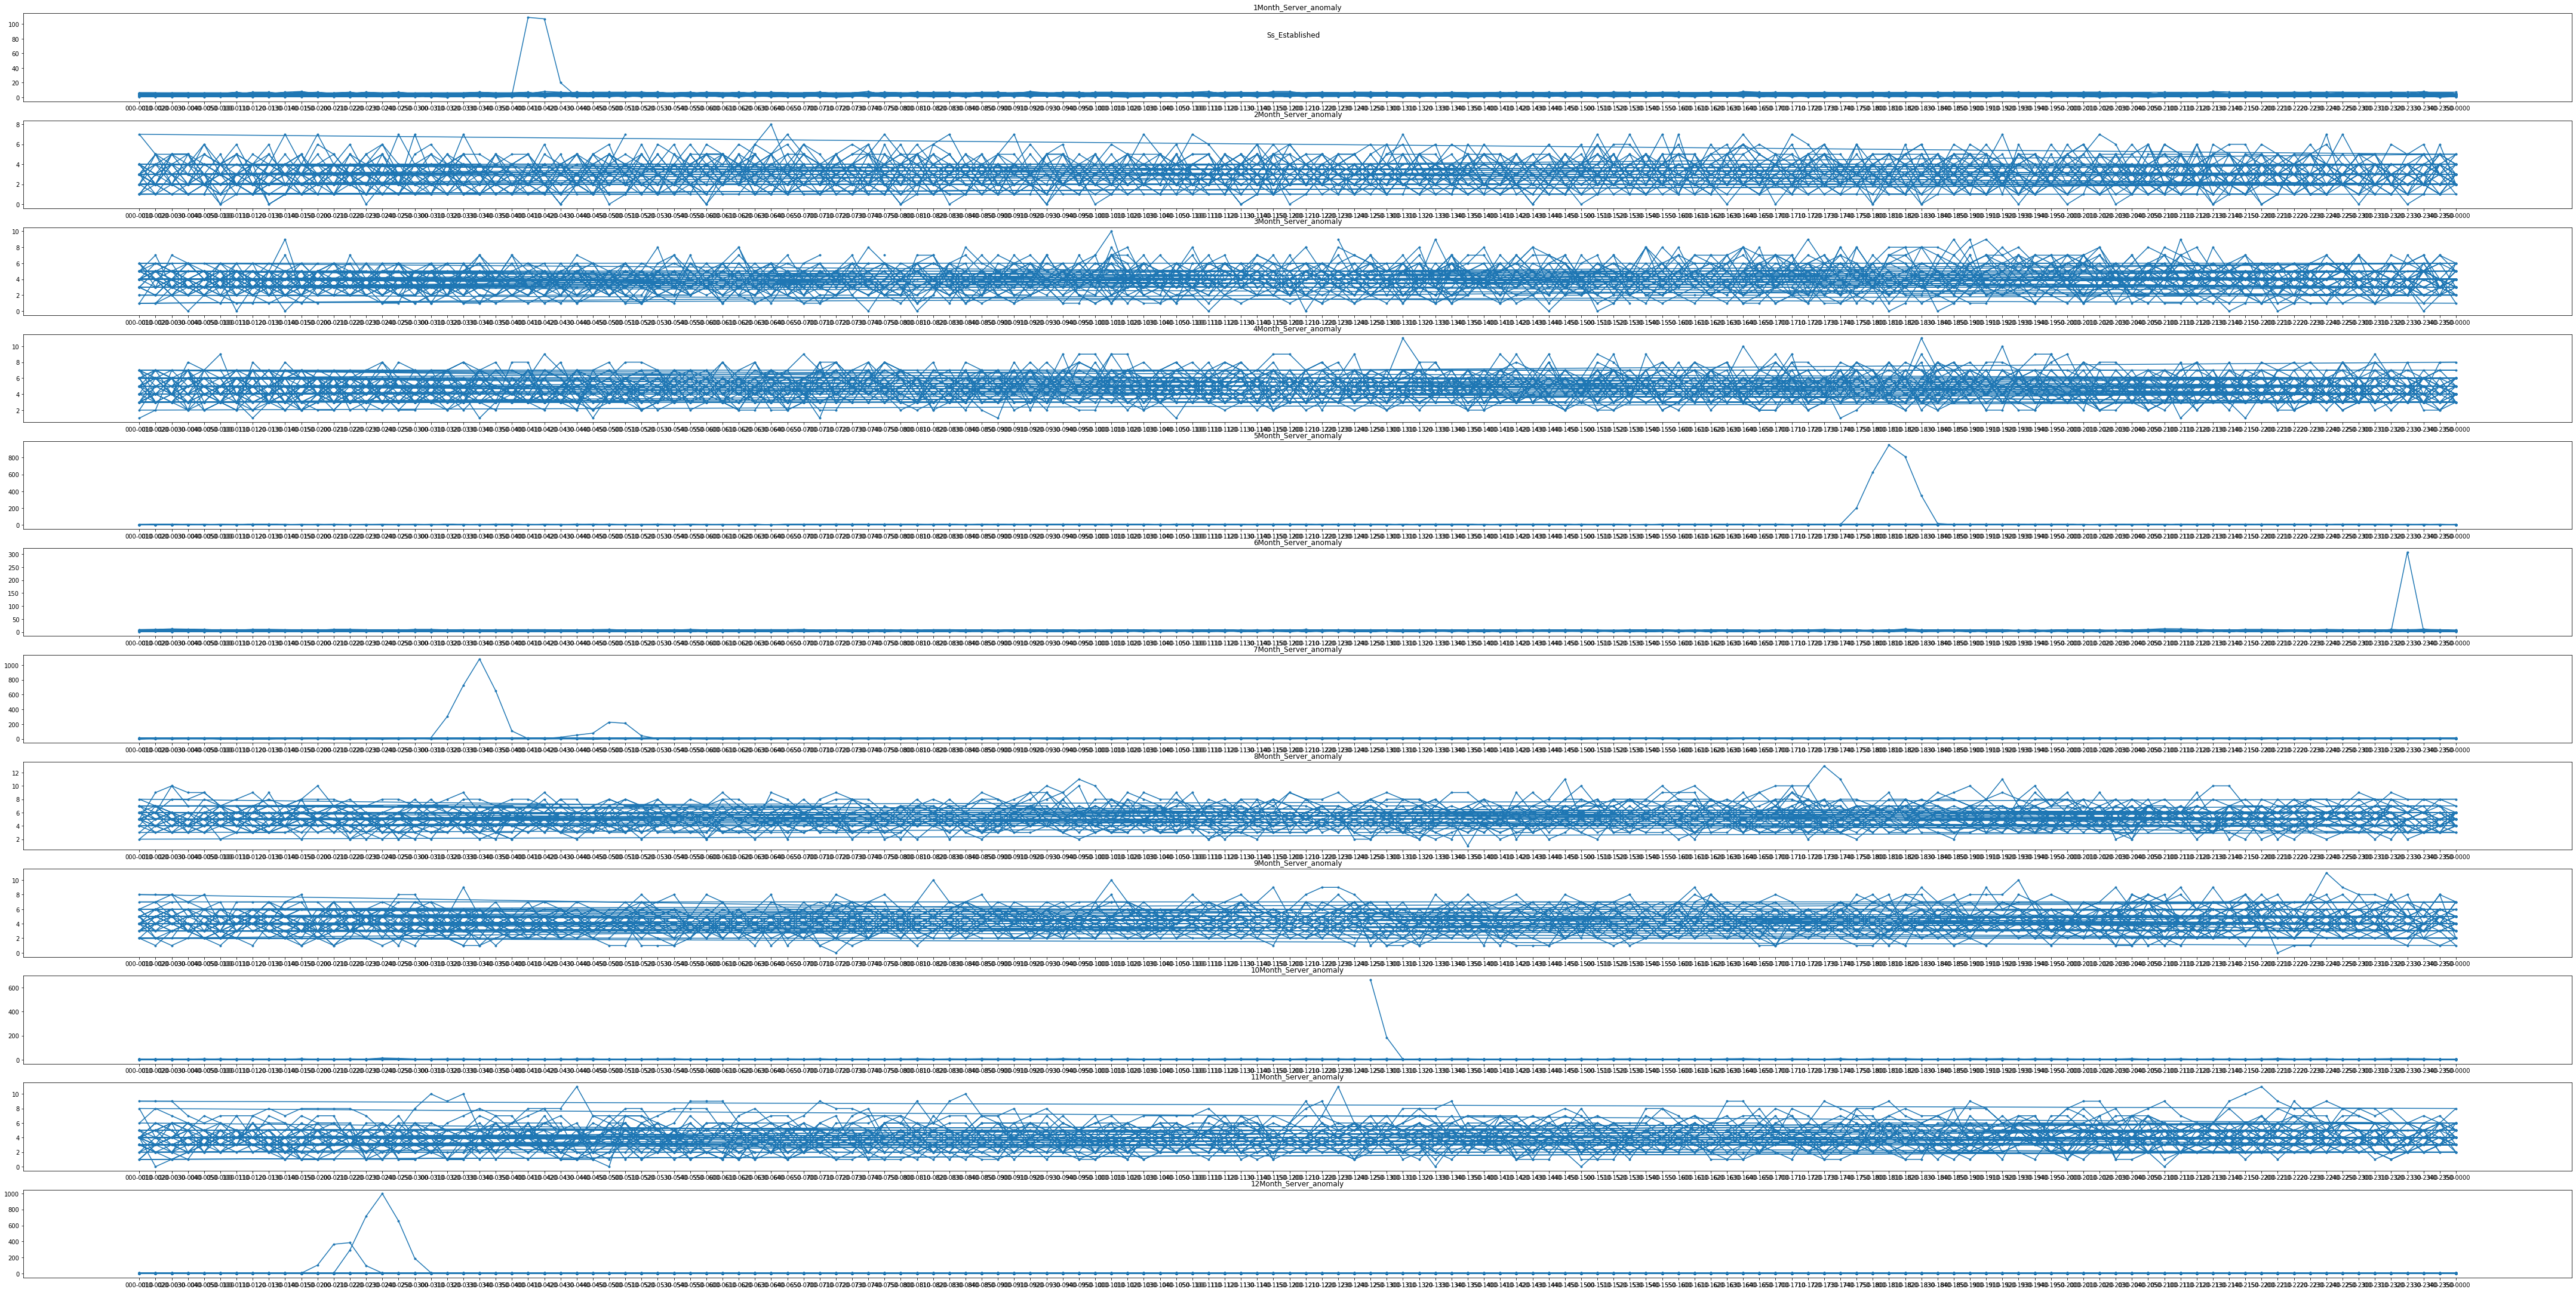

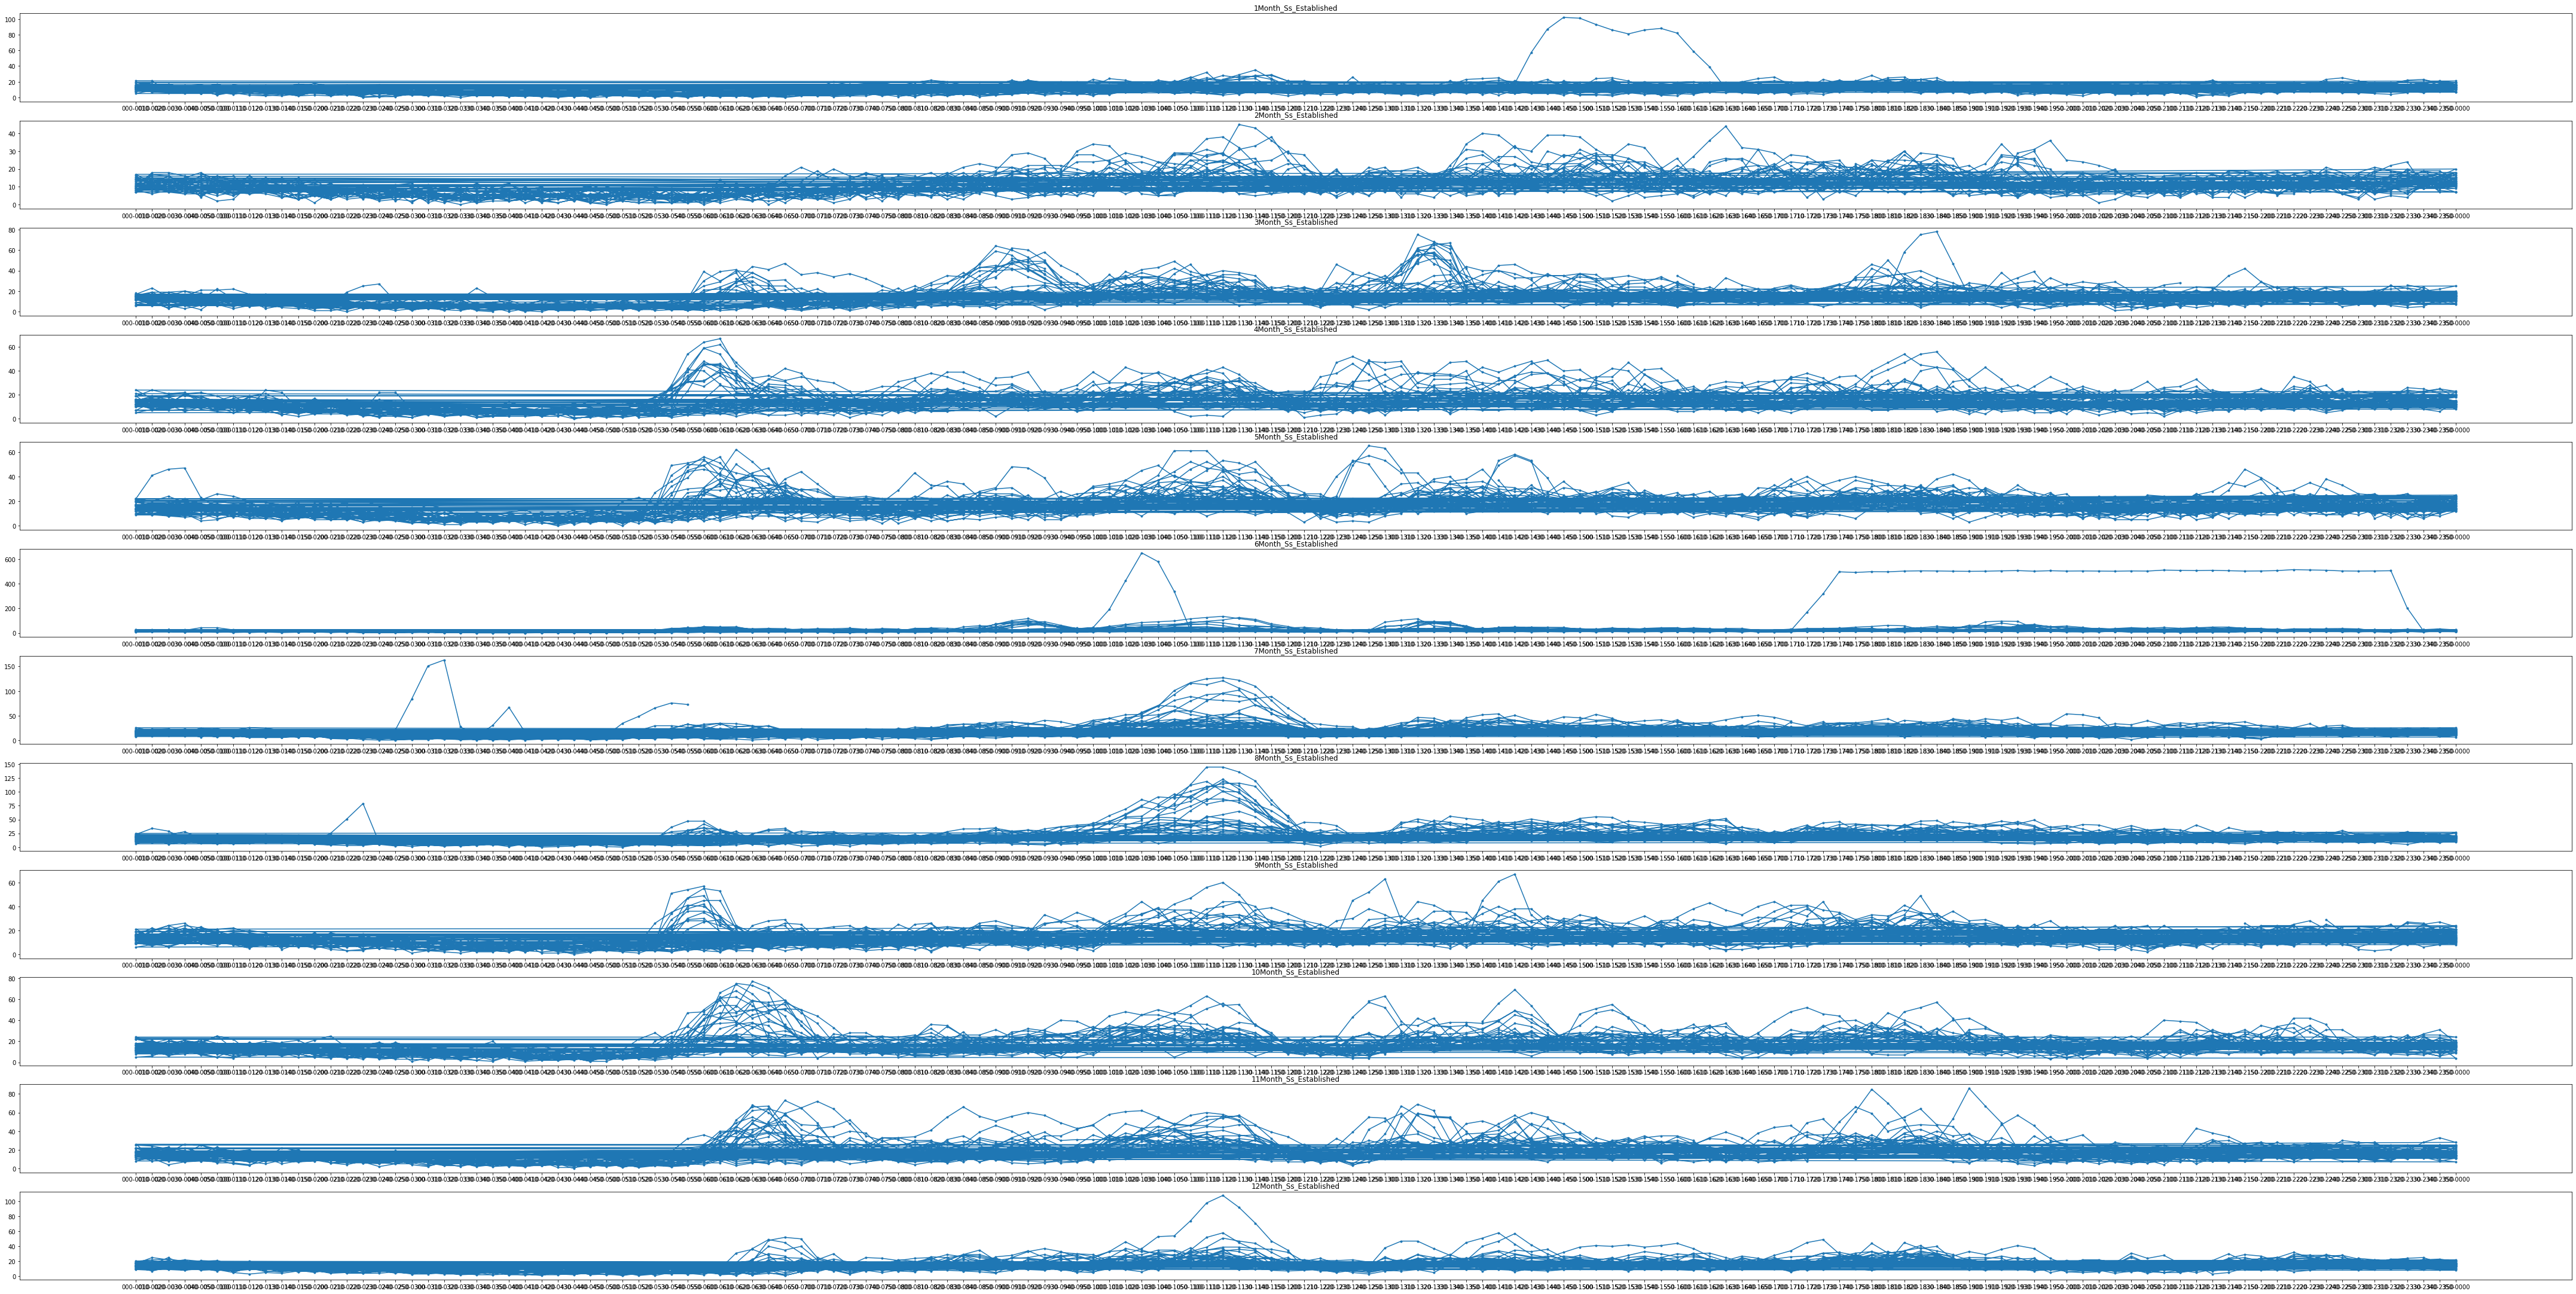

In [20]:
graph('Server_anomaly')
graph('Ss_Established')

In [ ]:
"""# null aggregate
def null_aggregate(df, agg_col):
  start_idx = df[agg_col].index.values[0]
  end_idx = df[agg_col].index.values[-1]
  for i in range(start_idx, end_idx):
    if df[agg_col][i] == np.nan:
      df[agg_col][i] = (df[agg_col][i-1] + df[agg_col][i+1])
  return df

DHCP['Ss_Established'] = null_aggregate(DHCP, 'Ss_Established')
DHCP['Server_anomaly'] = null_aggregate(DHCP, 'Server_anomaly')"""

"# null aggregate\ndef null_aggregate(df, agg_col):\n  start_idx = df[agg_col].index.values[0]\n  end_idx = df[agg_col].index.values[-1]\n  for i in range(start_idx, end_idx):\n    if df[agg_col][i] == np.nan:\n      df[agg_col][i] = (df[agg_col][i-1] + df[agg_col][i+1])\n  return df\n\nDHCP['Ss_Established'] = null_aggregate(DHCP, 'Ss_Established')\nDHCP['Server_anomaly'] = null_aggregate(DHCP, 'Server_anomaly')"

In [ ]:
"""
# isinstance(x, type) # x가 type이 맞는지 반환 True, False -> brownbears.tistory.com/155
# getattr(x, 'y', default) # x에 'y'라는 attribute(속성)이 있으면 y 출력 -> jeonghyeokpark.netlify.app/python/2020/12/11/python1.html

def Aggregate(df, agg_col, interval, agg_func):
  agg_func = [agg_func]

  start_idx = df[agg_col].index.values[0]
  end_idx = df[agg_col].index.values[-1]

  index_list = []
  agg_list = []

  while start_idx <= end_idx:
    interval_idx = start_idx + interval
    interval_set = df[agg_col].loc[start_idx:interval_idx-1]
    aggregated = interval_set.agg(agg_func, axis=0)
    index_list.append(start_idx)
    agg_list.append(aggregated)
    start_idx = interval_idx
  
  return np.asarray(index_list), np.asarray(agg_list)

index, DHCP_Ss_Established = Aggregate(DHCP, 'Ss_Established', 10, 'mean')
"""

"\n# isinstance(x, type) # x가 type이 맞는지 반환 True, False -> brownbears.tistory.com/155\n# getattr(x, 'y', default) # x에 'y'라는 attribute(속성)이 있으면 y 출력 -> jeonghyeokpark.netlify.app/python/2020/12/11/python1.html\n\ndef Aggregate(df, agg_col, interval, agg_func):\n  agg_func = [agg_func]\n\n  start_idx = df[agg_col].index.values[0]\n  end_idx = df[agg_col].index.values[-1]\n\n  index_list = []\n  agg_list = []\n\n  while start_idx <= end_idx:\n    interval_idx = start_idx + interval\n    interval_set = df[agg_col].loc[start_idx:interval_idx-1]\n    aggregated = interval_set.agg(agg_func, axis=0)\n    index_list.append(start_idx)\n    agg_list.append(aggregated)\n    start_idx = interval_idx\n  \n  return np.asarray(index_list), np.asarray(agg_list)\n\nindex, DHCP_Ss_Established = Aggregate(DHCP, 'Ss_Established', 10, 'mean')\n"

In [ ]:
index = np.asarray(DHCP.index)
DHCP_Ss_Established = np.asarray(DHCP.Ss_Established)
DHCP_Ss_Server_anomaly = np.asarray(DHCP.Server_anomaly)

In [ ]:
# Impute
# SimpleImputer : missing value를 특정한 값으로 채우는 기능을 제공

"""def Impute(df):
  imputer = SimpleImputer()
  df = imputer.fit_transform(df.reshape(-1,1))
  return df

DHCP_Ss_Established = Impute(DHCP_Ss_Established)
DHCP_Ss_Server_anomaly = Impute(DHCP_Ss_Server_anomaly)"""

'def Impute(df):\n  imputer = SimpleImputer()\n  df = imputer.fit_transform(df.reshape(-1,1))\n  return df\n\nDHCP_Ss_Established = Impute(DHCP_Ss_Established)\nDHCP_Ss_Server_anomaly = Impute(DHCP_Ss_Server_anomaly)'

In [ ]:
# Min-Max Normalize

"""def Normalize(df):
  df.copy()
  for col in df.columns:
    if df[col].dtype == 'float64':
      col_min = df[col].min()
      col_max = df[col].max()
      if col_min == col_max:
        df[col] = df[col] - col_min
      else:
        df[col] = (df[col] - col_min) / (col_max - col_min)
  return df"""

"""def Normalize(df):
  df.copy()
  if df.dtype == 'float64':
    df_min = df.min()
    df_max = df.max()
    if df_min == df_max:
      df = df - df_min
    else:
      df = (df - df_min) / (df_max - df_min)
  return df

DHCP_Ss_Established = Normalize(DHCP_Ss_Established)
DHCP_Ss_Server_anomaly = Normalize(DHCP_Ss_Server_anomaly)"""

"def Normalize(df):\n  df.copy()\n  if df.dtype == 'float64':\n    df_min = df.min()\n    df_max = df.max()\n    if df_min == df_max:\n      df = df - df_min\n    else:\n      df = (df - df_min) / (df_max - df_min)\n  return df\n\nDHCP_Ss_Established = Normalize(DHCP_Ss_Established)\nDHCP_Ss_Server_anomaly = Normalize(DHCP_Ss_Server_anomaly)"

In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler

imp = SimpleImputer()
DHCP_Ss_Established = imp.fit_transform(DHCP_Ss_Established.reshape(-1,1))

scaler = MinMaxScaler(feature_range=(0, 1))
DHCP_Ss_Established = scaler.fit_transform(DHCP_Ss_Established)

imp = SimpleImputer()
DHCP_Ss_Server_anomaly = imp.fit_transform(DHCP_Ss_Server_anomaly.reshape(-1,1))

scaler = MinMaxScaler(feature_range=(0, 1))
DHCP_Ss_Server_anomaly = scaler.fit_transform(DHCP_Ss_Server_anomaly)

In [ ]:
#X = DHCP_Ss_Established
#X_server = DHCP_Ss_Server_anomaly

In [ ]:
def rolling_window_sequences(X, index, window_size, target_size, step_size, target_column,
                             drop=None, drop_windows=False):
    out_X = list()
    out_y = list()
    X_index = list()
    y_index = list()
    target = X[:, target_column]

    if drop_windows:
        if hasattr(drop, '__len__') and (not isinstance(drop, str)):
            if len(drop) != len(X):
                raise Exception('Arrays `drop` and `X` must be of the same length.')
        else:
            if isinstance(drop, float) and np.isnan(drop):
                drop = np.isnan(X)
            else:
                drop = X == drop

    start = 0
    max_start = len(X) - window_size - target_size + 1
    while start < max_start:
        end = start + window_size

        if drop_windows:
            drop_window = drop[start:end + target_size]
            to_drop = np.where(drop_window)[0]
            if to_drop.size:
                start += to_drop[-1] + 1
                continue

        out_X.append(X[start:end])
        out_y.append(target[end:end + target_size])
        X_index.append(index[start])
        y_index.append(index[end])
        start = start + step_size

    return np.asarray(out_X), np.asarray(out_y), np.asarray(X_index), np.asarray(y_index)

X, y, X_index, y_index = rolling_window_sequences(DHCP_Ss_Established, index, window_size = 100, target_size = 1, step_size = 1, target_column = 0)
X_server, y_server, X_server_index, y_server_index = rolling_window_sequences(DHCP_Ss_Server_anomaly, index, window_size = 100, target_size = 1, step_size = 1, target_column = 0)

In [ ]:
"""# Rolling Window

def Rolling_Window(df, index, window_size, target_size, step_size):

  #df : 반복할 N차원 시퀸스
  #index : df의 인덱스 값을 포함하는 배열
  #window_size : 입력 시퀸스의 길이
  #target_size : 대상 시퀸스의 길이
  #step_size : 각 라운드에서 창을 앞으로 이동하는 단계 수

  x_out = []
  y_out = []
  x_idx = []
  y_idx = []

  #x_out, y_out, x_idx, y_idx = list(), list(), list(), list()

  start_idx = 0
  while start_idx < len(df) - window_size - target_size + 1:
    step_idx = start_idx + window_size # step_idx = 0 + 3 / 3 + 3 / ...
    window = df[start_idx:step_idx + target_size] # 윈도우
    window_idx = np.where(window)[0] # 조건에 만족하는 인덱스 추출
    x_out.append(df[start_idx:step_idx])
    y_out.append(df[step_idx:step_idx + target_size])
    x_idx.append(index[start_idx])
    y_idx.append(index[step_idx])
    start_idx += step_size

  return np.asarray(x_out), np.asarray(y_out), np.asarray(x_idx), np.asarray(y_idx)

X, y, X_index, y_index = Rolling_Window(DHCP_Ss_Established, index, window_size = 100, target_size = 1, step_size = 1)
X_server, y_server, X_server_index, y_server_index = Rolling_Window(DHCP_Ss_Server_anomaly, index, window_size = 100, target_size = 1, step_size = 1)"""

'# Rolling Window\n\ndef Rolling_Window(df, index, window_size, target_size, step_size):\n\n  #df : 반복할 N차원 시퀸스\n  #index : df의 인덱스 값을 포함하는 배열\n  #window_size : 입력 시퀸스의 길이\n  #target_size : 대상 시퀸스의 길이\n  #step_size : 각 라운드에서 창을 앞으로 이동하는 단계 수\n\n  x_out = []\n  y_out = []\n  x_idx = []\n  y_idx = []\n\n  #x_out, y_out, x_idx, y_idx = list(), list(), list(), list()\n\n  start_idx = 0\n  while start_idx < len(df) - window_size - target_size + 1:\n    step_idx = start_idx + window_size # step_idx = 0 + 3 / 3 + 3 / ...\n    window = df[start_idx:step_idx + target_size] # 윈도우\n    window_idx = np.where(window)[0] # 조건에 만족하는 인덱스 추출\n    x_out.append(df[start_idx:step_idx])\n    y_out.append(df[step_idx:step_idx + target_size])\n    x_idx.append(index[start_idx])\n    y_idx.append(index[step_idx])\n    start_idx += step_size\n\n  return np.asarray(x_out), np.asarray(y_out), np.asarray(x_idx), np.asarray(y_idx)\n\nX, y, X_index, y_index = Rolling_Window(DHCP_Ss_Established, index, window_size =

In [ ]:
# 1:100 + target
# 2:101 + target
# 3:102 + target

In [ ]:
"""# Rolling Window

def Rolling_Window(df, index, window_size, step_size):

  #df : 반복할 N차원 시퀸스
  #index : df의 인덱스 값을 포함하는 배열
  #window_size : 입력 시퀸스의 길이
  #target_size : 대상 시퀸스의 길이
  #step_size : 각 라운드에서 창을 앞으로 이동하는 단계 수

  x_out = []
  y_out = []
  x_idx = []
  y_idx = []

  #x_out, y_out, x_idx, y_idx = list(), list(), list(), list()

  start_idx = 0
  while start_idx < len(df) - window_size + 1:
    step_idx = start_idx + window_size # step_idx = 0 + 3 / 3 + 3 / ...
    window = df[start_idx:step_idx] # 윈도우
    window_idx = np.where(window)[0] # 조건에 만족하는 인덱스 추출
    x_out.append(df[start_idx:step_idx])
    y_out.append(df[step_idx:step_idx])
    x_idx.append(index[start_idx])
    y_idx.append(index[step_idx - window_size])
    start_idx += step_size

  return np.asarray(x_out), np.asarray(y_out), np.asarray(x_idx), np.asarray(y_idx)

X, y, X_index, y_index = Rolling_Window(DHCP_Ss_Established, index, window_size = 100, step_size = 1)
X_server, y_server, X_server_index, y_server_index = Rolling_Window(DHCP_Ss_Server_anomaly, index, window_size = 100, step_size = 1)"""

'# Rolling Window\n\ndef Rolling_Window(df, index, window_size, step_size):\n\n  #df : 반복할 N차원 시퀸스\n  #index : df의 인덱스 값을 포함하는 배열\n  #window_size : 입력 시퀸스의 길이\n  #target_size : 대상 시퀸스의 길이\n  #step_size : 각 라운드에서 창을 앞으로 이동하는 단계 수\n\n  x_out = []\n  y_out = []\n  x_idx = []\n  y_idx = []\n\n  #x_out, y_out, x_idx, y_idx = list(), list(), list(), list()\n\n  start_idx = 0\n  while start_idx < len(df) - window_size + 1:\n    step_idx = start_idx + window_size # step_idx = 0 + 3 / 3 + 3 / ...\n    window = df[start_idx:step_idx] # 윈도우\n    window_idx = np.where(window)[0] # 조건에 만족하는 인덱스 추출\n    x_out.append(df[start_idx:step_idx])\n    y_out.append(df[step_idx:step_idx])\n    x_idx.append(index[start_idx])\n    y_idx.append(index[step_idx - window_size])\n    start_idx += step_size\n\n  return np.asarray(x_out), np.asarray(y_out), np.asarray(x_idx), np.asarray(y_idx)\n\nX, y, X_index, y_index = Rolling_Window(DHCP_Ss_Established, index, window_size = 100, step_size = 1)\nX_server, y_server,

In [ ]:
print(DHCP.index[DHCP.Timestamp < '202107'][0])
print(DHCP.index[DHCP.Timestamp >= '202107'][0])

In [ ]:
X_train = X[:]
X_test = X[:]

In [ ]:
Ss_Established_train = DHCP.loc[DHCP.Timestamp < '202107', 'Ss_Established']
DHCP_Ss_Server_anomaly_train = DHCP.loc[DHCP.Timestamp < '202107', 'Server_anomaly']

Ss_Established_test = DHCP.loc[DHCP.Timestamp >= '202107', 'Ss_Established']
DHCP_Ss_Server_anomaly_test = DHCP.loc[DHCP.Timestamp >= '202107', 'Server_anomaly']

In [ ]:
Ss_Established_train.shape, DHCP_Ss_Server_anomaly_train.shape, Ss_Established_test.shape, DHCP_Ss_Server_anomaly_test.shape

((26496,), (26496,))

In [ ]:
print("Training DHCP_Ss_Established input shape: {}".format(X.shape))
print("Training DHCP_Ss_Server_anomaly input shape: {}".format(X_server.shape))
print(y.shape)
print(y_server.shape)
print(X_index.shape)
print(X_server_index.shape)
print(y_index.shape)
print(y_server_index.shape)

Training DHCP_Ss_Established input shape: (52460, 100, 1)
Training DHCP_Ss_Server_anomaly input shape: (52460, 100, 1)
(52460, 1)
(52460, 1)
(52460,)
(52460,)
(52460,)
(52460,)


In [ ]:
def sequences(values, step_size):
  output = []
  for i in range(len(values) - step_size + 1):
    output.append(values[i : (i + step_size)])
  return np.stack(output)

X = sequences(DHCP_Ss_Established, 100)
print('Training data input shape: {}'.format(X.shape))

Training data input shape: (52461, 100, 1)


In [ ]:
from model import hyperparameters
from orion.primitives.tadgan import TadGAN
from orion.data import load_signal, load_anomalies
from orion import Orion

In [ ]:
hyperparameters["epochs"] = 40 # 40 35
hyperparameters["shape"] = (100, 1) # based on the window size
hyperparameters["optimizer"] = "keras.optimizers.Adam" # AdamW
hyperparameters["learning_rate"] = 0.0005
hyperparameters["latent_dim"] = 20
hyperparameters["batch_size"] = 64

# 0 ~ 1 scaling -> sigmoid (default : tanh)
#hyperparameters['layers_generator'][7]['parameters']['activation'] = 'sigmoid'

tgan = TadGAN(**hyperparameters)
tgan.fit(X_server)

Epoch: 1/40, [Dx loss: [ 0.08705304  0.9946309  -1.1278654   0.02202884]] [Dz loss: [-3.032      -3.5034695  -0.5318946   0.10033654]] [G loss: [2.4621158  1.2252321  1.1255409  0.01113431]]
Epoch: 2/40, [Dx loss: [-0.01313858 -3.8243608   3.7519226   0.00592961]] [Dz loss: [-0.42472613  3.4762306  -4.7779803   0.08770211]] [G loss: [ 1.9837201  -3.730415    5.6428657   0.00712675]]
Epoch: 3/40, [Dx loss: [-0.04017132 -3.4756346   3.3700478   0.00654136]] [Dz loss: [-1.6861335  -1.0927491  -1.0717876   0.04784029]] [G loss: [-2.071334   -3.3658688   1.253461    0.00410714]]
Epoch: 4/40, [Dx loss: [-0.01033635 -1.1401832   1.0850962   0.00447511]] [Dz loss: [-2.984076   -6.070336    2.6092124   0.04770473]] [G loss: [-3.5773127e+00 -1.0311565e+00 -2.5519159e+00  5.7600613e-04]]
Epoch: 5/40, [Dx loss: [-2.0963170e-02  1.5306425e+01 -1.5365506e+01  3.8125359e-03]] [Dz loss: [-3.5145407  -5.693972    1.6679343   0.05114977]] [G loss: [ 1.3764830e+01  1.5388982e+01 -1.6358538e+00  1.1699315

In [ ]:
# bearing tadGAN

#tgan = TadGAN(**hyperparameters)
#tgan.fit(Ss_Established_train)
#X_pred_train, critic_train = tgan.predict(Ss_Established_test)

#tgan = TadGAN(**hyperparameters)
#tgan.fit(DHCP_Ss_Server_anomaly_train)
X_server_pred_test, critic_server_test = tgan.predict(DHCP_Ss_Server_anomaly_test)

In [ ]:
#X_pred, critic = tgan.predict(X)
X_server_pred, critic_server = tgan.predict(X_server)

In [ ]:
#X_pred
X_server_pred

array([[[-0.0693333 ],
        [-0.04195482],
        [-0.00371906],
        ...,
        [-0.01680377],
        [-0.01034173],
        [-0.00107863]],

       [[-0.07181352],
        [-0.04424381],
        [-0.00532657],
        ...,
        [-0.01596583],
        [-0.01005739],
        [-0.00111302]],

       [[-0.07464048],
        [-0.04712348],
        [-0.00704919],
        ...,
        [-0.01497249],
        [-0.00976884],
        [-0.00115563]],

       ...,

       [[-0.07255475],
        [-0.05080237],
        [-0.0124395 ],
        ...,
        [-0.01640243],
        [-0.01166469],
        [-0.00292879]],

       [[-0.07671233],
        [-0.05403562],
        [-0.01331681],
        ...,
        [-0.01577529],
        [-0.01142697],
        [-0.00274512]],

       [[-0.08006011],
        [-0.05673463],
        [-0.01416111],
        ...,
        [-0.01461148],
        [-0.01102653],
        [-0.00263513]]], dtype=float32)

In [ ]:
#critic
critic_server

array([[237.24213],
       [237.24222],
       [237.24152],
       ...,
       [237.24443],
       [237.24384],
       [237.24394]], dtype=float32)

In [ ]:
#np.save('X_pred_epoch40.npy', X_pred)
np.save('X_server_pred_epoch40.npy', X_server_pred)

In [ ]:
#np.save('critic_epoch40.npy', critic)
np.save('critic_server_epoch40.npy', critic_server)

In [ ]:
X_pred = np.load('X_pred_epoch40.npy')
X_server_pred = np.load('X_server_pred_epoch40.npy')
critic = np.load('critic_epoch40.npy')
critic_server = np.load('critic_server_epoch40.npy')

In [ ]:
from utils import plot, plot_ts, plot_rws, plot_error, unroll_ts

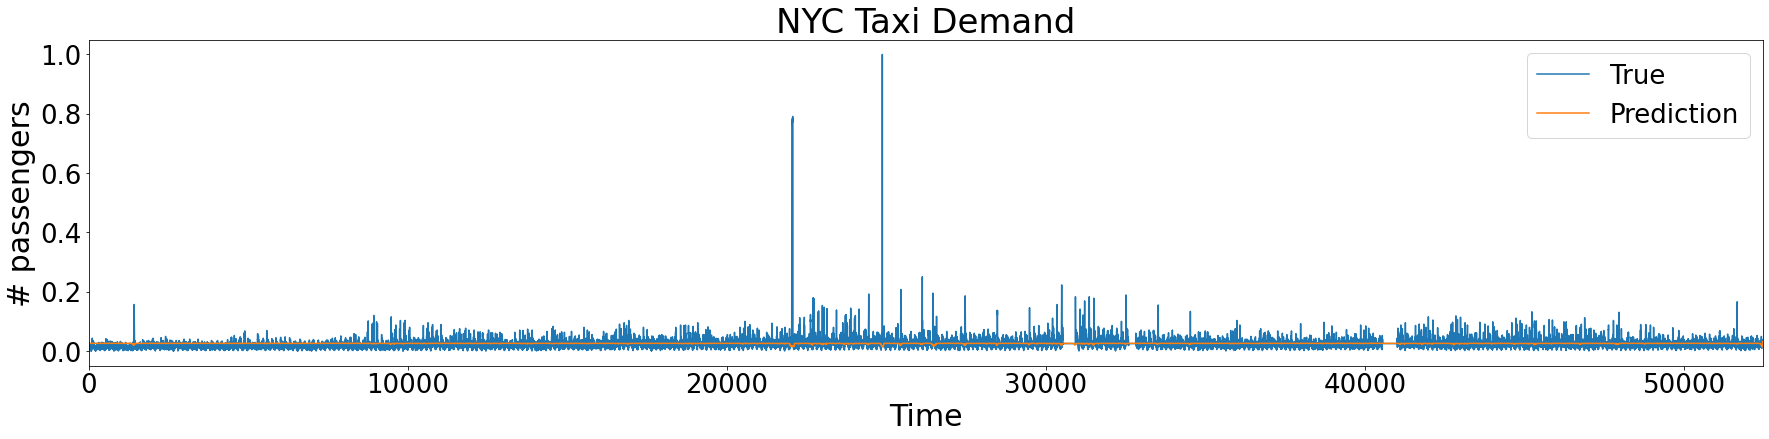

In [ ]:
y_pred = unroll_ts(X_pred)
y_reshape = y.reshape(-1)
plot_ts([y_reshape, y_pred], labels = ['True', 'Prediction'])

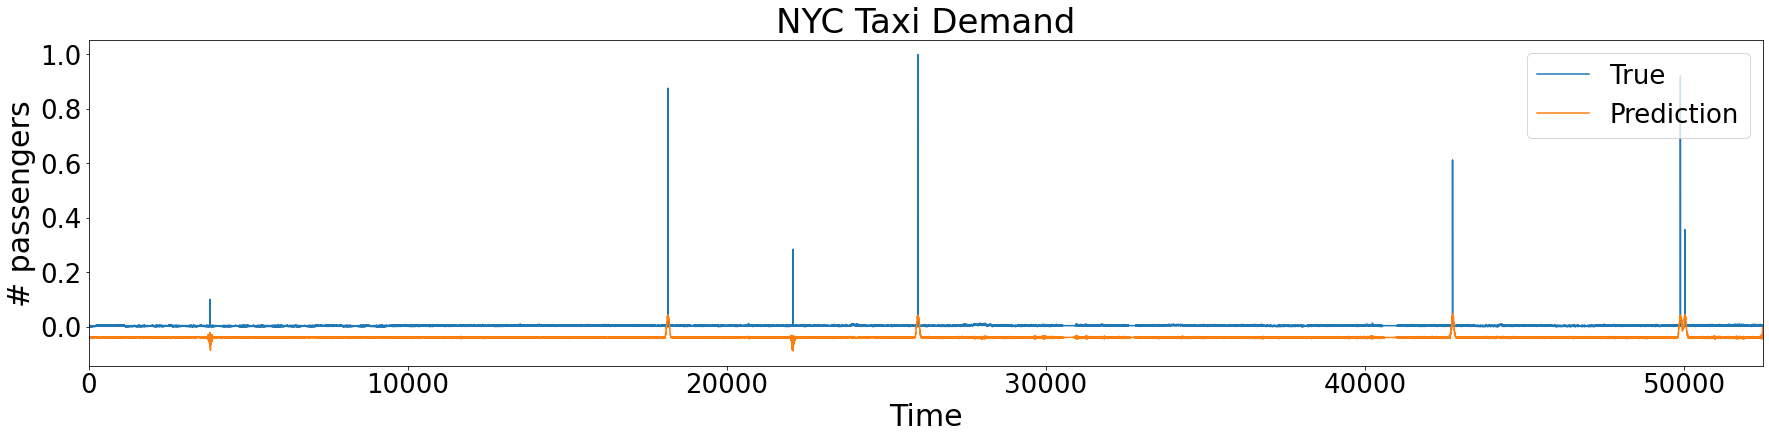

In [ ]:
#y_pred = unroll_ts(X_pred)
y_server_pred = unroll_ts(X_server_pred)
#y_reshape = y.reshape(-1)
y_server_reshape = y_server.reshape(-1)
#plot_ts([y_reshape, y_pred], labels = ['True', 'Prediction'])
plot_ts([y_server_reshape, y_server_pred], labels = ['True', 'Prediction'])

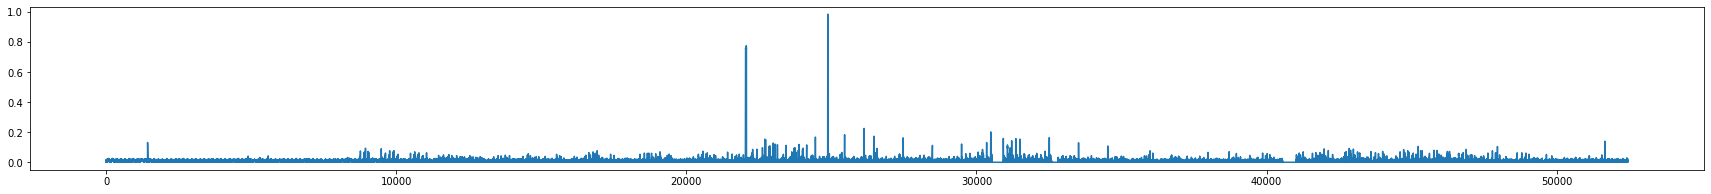

In [ ]:
error = np.zeros(shape = y_reshape.shape)
length = y_reshape.shape[0]

for i in range(length):
  error[i] = abs(y_reshape[i] - y_pred[i])

fig = plt.figure(figsize = (30,3))
plt.plot(error)
plt.show()

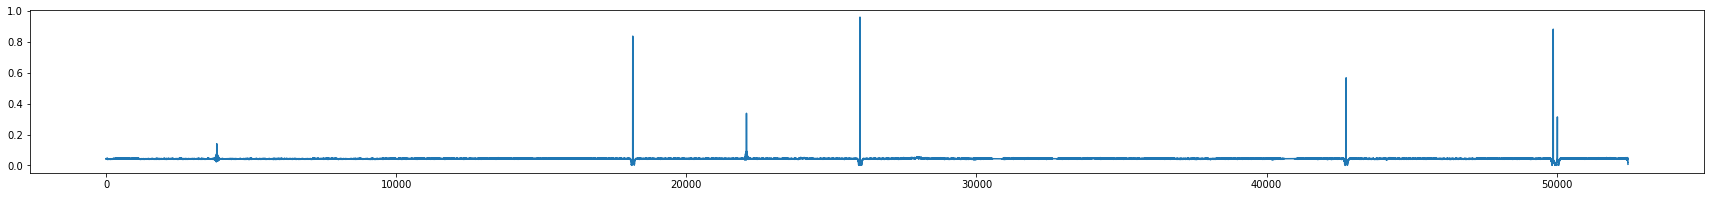

In [ ]:
error_server = np.zeros(shape = y_server_reshape.shape)
length_server = y_server_reshape.shape[0]

for i in range(length_server):
  error_server[i] = abs(y_server_reshape[i] - y_server_pred[i])

fig = plt.figure(figsize = (30,3))
plt.plot(error_server)
plt.show()

In [ ]:
from orion.primitives.tadgan import score_anomalies

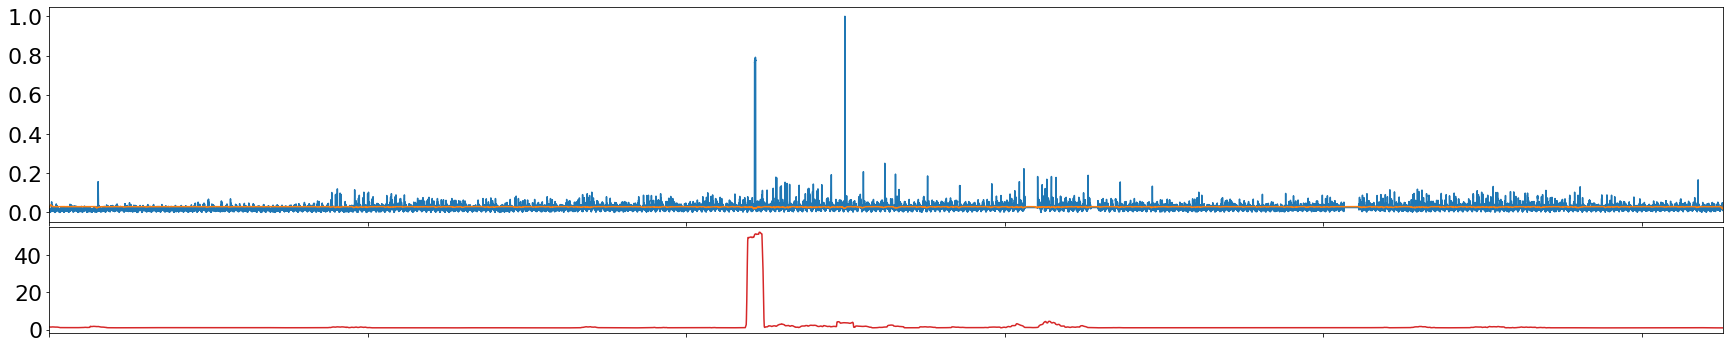

In [ ]:
error_, true_index, true, pred = score_anomalies(X, X_pred, critic, X_index, rec_error_type="dtw", comb="mult")
pred = np.array(pred).mean(axis=2)

plot_error([[true, pred], error_])

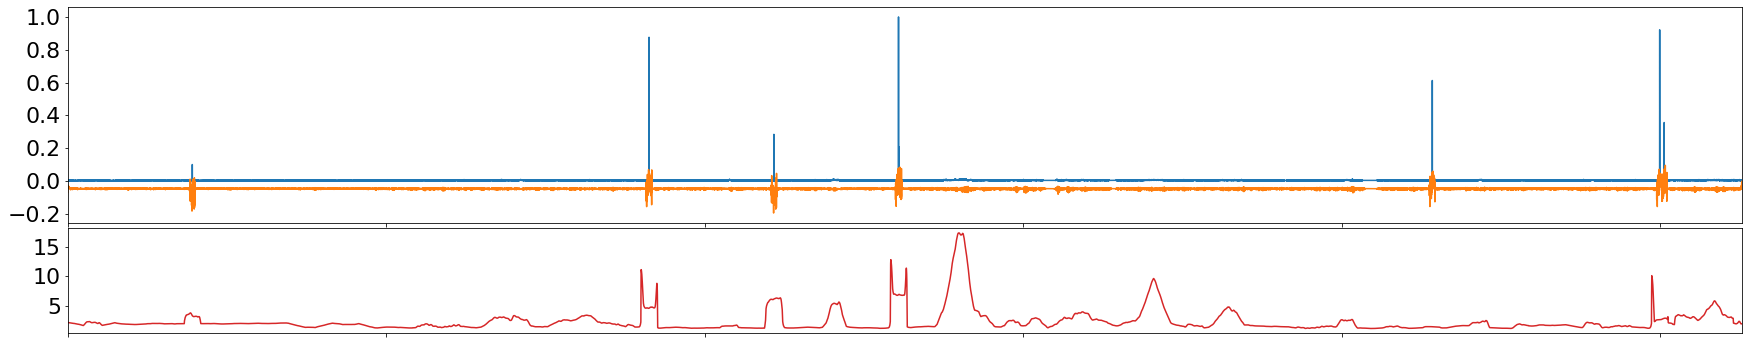

In [ ]:
error_server_, ture_server_index, true_server, pred_server = score_anomalies(X_server, X_server_pred, critic_server, X_server_index, rec_error_type="dtw", comb="mult")
pred_server = np.array(pred_server).mean(axis=2)

plot_error([[true_server, pred_server], error_server_])

best threshold

In [ ]:
#DHCP[DHCP.Timestamp > '202107'] # 26064
#DHCP[DHCP.Timestamp > '202108'] # 30528
#DHCP[DHCP.Timestamp > '202109'] # 34992
#DHCP[DHCP.Timestamp > '202110'] # 39312
#DHCP[DHCP.Timestamp > '202111'] # 43776

In [ ]:
submission = pd.DataFrame(columns=['error_', 'error_server_'])
error_append = np.append(error_,0)
error_server_append = np.append(error_server_,0)
submission['error_'] = error_append
submission['error_server_'] = error_server_append

In [ ]:
submission = submission.set_index(DHCP.Timestamp).reset_index()
submission['Prediction'] = 0

In [ ]:
data07 = submission.loc[(submission.Timestamp > '202107') & (submission.Timestamp <= '202108'), 'error_']
mean07 = np.mean(data07)
std07 = np.std(data07)
q07 = np.quantile(data07, 1) - 0.9
data07_server = submission.loc[(submission.Timestamp > '202107') & (submission.Timestamp <= '202108'), 'error_server_']
mean07_server = np.mean(data07_server)
std07_server = np.std(data07_server)
q07_server = np.quantile(data07_server, 1) - 0.9
print(q07_server)
submission.loc[(submission.Timestamp > '202107') & (submission.Timestamp <= '202108') & ((submission.error_ > q07 + 1) | (submission.error_server_ > q07_server + 1)), 'Prediction'] = 1

data08 = submission.loc[(submission.Timestamp > '202108') & (submission.Timestamp <= '202109'), 'error_']
mean08 = np.mean(data08)
std08 = np.std(data08)
q08 = np.quantile(data08, 1) - 0.9
data08_server = submission.loc[(submission.Timestamp > '202108') & (submission.Timestamp <= '202109'), 'error_server_']
mean08_server = np.mean(data08_server)
std08_server = np.std(data08_server)
q08_server = np.quantile(data08_server, 1) - 0.9
print(q08_server)
submission.loc[(submission.Timestamp > '202108') & (submission.Timestamp <= '202109') & ((submission.error_ > q08 + 1) | (submission.error_server_ > q08_server + 1)), 'Prediction'] = 1

data09 = submission.loc[(submission.Timestamp > '202109') & (submission.Timestamp <= '202110'), 'error_']
mean09 = np.mean(data09)
std09 = np.std(data09)
q09 = np.quantile(data09, 1) - 0.9
data09_server = submission.loc[(submission.Timestamp > '202109') & (submission.Timestamp <= '202110'), 'error_server_']
mean09_server = np.mean(data09_server)
std09_server = np.std(data09_server)
q09_server = np.quantile(data09_server, 1) - 0.9
print(q09_server)
submission.loc[(submission.Timestamp > '202109') & (submission.Timestamp <= '202110') & ((submission.error_ > q09 + 1) | (submission.error_server_ > q09_server + 1)), 'Prediction'] = 1

data10 = submission.loc[(submission.Timestamp > '202110') & (submission.Timestamp <= '202111'), 'error_']
mean10 = np.mean(data10)
std10 = np.std(data10)
q10 = np.quantile(data10, 1) - 0.9
data10_server = submission.loc[(submission.Timestamp > '202110') & (submission.Timestamp <= '202111'), 'error_server_']
mean10_server = np.mean(data10_server)
std10_server = np.std(data10_server)
q10_server = np.quantile(data10, 1) - 0.9
print(q10_server)
submission.loc[(submission.Timestamp > '202110') & (submission.Timestamp <= '202111') & ((submission.error_ > q10 + 1) | (submission.error_server_ > q10_server + 1)), 'Prediction'] = 1

data11 = submission.loc[(submission.Timestamp > '202111'), 'error_']
mean11 = np.mean(data11)
std11 = np.std(data11)
q11 = np.quantile(data11, 1) - 0.9
data11_server = submission.loc[(submission.Timestamp > '202111'), 'error_server_']
mean11_server = np.mean(data11_server)
std11_server = np.std(data11_server)
q11_server = np.quantile(data11_server, 1) - 0.9
print(q11_server)
submission.loc[(submission.Timestamp > '202111') & ((submission.error_ > q11 + 1) | (submission.error_server_ > q11_server + 1)), 'Prediction'] = 1

16.521761264723395
8.721297401925295
3.8652522340253976
0.9035739279054796
9.215623512769719


In [ ]:
submission['Prediction'].value_counts()

0    52064
1      496
Name: Prediction, dtype: int64

In [ ]:
answer = pd.DataFrame(submission['Prediction'][submission.Timestamp > '202107'],columns = ['Prediction'])
answer.to_csv('IP_answer.csv', index = False)

In [ ]:
answer.Prediction.value_counts()

0    23998
1     2498
Name: Prediction, dtype: int64

In [ ]:
answer.head()

Prediction
26064           0
26065           0
26066           0
26067           0
26068           0

In [ ]:
anomaly_mask = np.where(error_tp > threshold_tp. 1. 0).reshape(-1)
arrays = np.append(anomaly_mask, [0], axis=0)
submission = pd.DataFrame(arrays, columns = ['Prediction'])
submission = submission.set_index(DHCP.Timestamp).reset_index()
answer = pd.DataFrame(submission['Prediction'][submission.Timestamp > '202107'],columns = ['Prediction'])
answer.to_csv('IP_answer.csv', index = False)

In [ ]:
np.mean(error_) + np.std(error_), np.mean(error_server_) + np.std(error_server_)

(6.4983674091476065, 4.204897889144187)

In [ ]:
np.mean(error_) + (np.std(error_)/2), np.mean(error_server_) + (np.std(error_server_)/2)

(4.125332527424655, 3.2399889102883823)

In [ ]:
np.mean(error_), np.mean(error_server_)

(1.7522976457017048, 2.275079931432578)

In [ ]:
np.std(error_), np.std(error_server_)

(4.7460697634459015, 1.9298179577116084)

In [ ]:
len(error_[error_ > 10]), len(error_server_[error_server_ > 10])

(540, 692)

In [ ]:
#error_ version
# 12/ 18/ 16.5/ 14/ 15/ 13
threshold = 4.519953919134558
anomaly_mask = np.where(error_ > threshold, 1, 0).reshape(-1)

arrays = np.append(anomaly_mask, [0], axis=0)
submission = pd.DataFrame(arrays, columns = ['Prediction'])
submission = submission.set_index(DHCP.Timestamp).reset_index()
answer = pd.DataFrame(submission['Prediction'][submission.Timestamp > '202107'],columns = ['Prediction'])
answer.to_csv('IP_answer.csv', index = False)

In [ ]:
#error_server_ version
threshold_server = 17.371761264723393
server_anomaly_mask = np.where(error_server_ > threshold_server, 1, 0).reshape(-1)

arrays = np.append(server_anomaly_mask, [0], axis=0)
submission = pd.DataFrame(arrays, columns = ['Prediction'])
submission = submission.set_index(DHCP.Timestamp).reset_index()
answer = pd.DataFrame(submission['Prediction'][submission.Timestamp > '202107'],columns = ['Prediction'])
answer.to_csv('IP_answer.csv', index = False)

In [ ]:
np.quantile(error_, 0), np.quantile(error_, 1)

(1.0223400642647902, 52.202466016105326)

In [ ]:
np.mean(answer['error_']) + np.std(answer['error_'])

1.7263625564639582

In [ ]:
np.mean(answer['error_server_']) + np.std(answer['error_server_'])

4.94289015168507

In [ ]:
error_arrays = np.append(error_, [0], axis=0)
submission = pd.DataFrame(error_arrays, columns = ['error_'])
submission = submission.set_index(DHCP.Timestamp).reset_index()
answer = pd.DataFrame(submission['error_'][submission.Timestamp >= '202107'],columns = ['error_'])
np.quantile(answer['error_'], 1) # 0.85

4.569953919134558

In [ ]:
error_server_arrays = np.append(error_server_, [0], axis=0)
submission = pd.DataFrame(error_server_arrays, columns = ['error_server_'])
submission = submission.set_index(DHCP.Timestamp).reset_index()
answer = pd.DataFrame(submission['error_server_'][submission.Timestamp >= '202107'],columns = ['error_server_'])
np.quantile(answer['error_server_'], 1) # 0.85

17.421761264723393

In [ ]:
#error_ & error_server_ version
threshold = 4
threshold_server = 17
two_anomaly_mask = np.where(((error_ > threshold) | (error_server_ > threshold_server)), 1, 0).reshape(-1)

arrays = np.append(two_anomaly_mask, [0], axis=0)
submission = pd.DataFrame(arrays, columns = ['Prediction'])
submission = submission.set_index(DHCP.Timestamp).reset_index()
answer = pd.DataFrame(submission['Prediction'][submission.Timestamp >= '202107'],columns = ['Prediction'])
answer.to_csv('IP_answer.csv', index = False)

In [ ]:
answer.Prediction.value_counts()

0    26141
1      355
Name: Prediction, dtype: int64